### Compare vapor pressure trends in different reanalysis datasets with those in the station data.
### Also comparing the different methods (calculated based on specific humidity or based on dew point temperature for JRA-55

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan

from qtrendutils import linfit_utils as linfit
from qtrendutils import mapplot_utils as mymaps
from qtrendutils import colorbar_utils as cbars
from qtrendutils import calendar_utils as cal

import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Arial')


In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"

In [3]:
landfrac = xr.open_dataset("../../DATA_SORT/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = landfrac.where(landfrac > 0, nan)
landfrac = landfrac.where(landfrac.lat > -60, nan) # omitting Antarctica

### Map data

In [4]:
#---ISD
isddat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge4pd.nc")

# drop stations that have more than 48 months with less than 15 bad days
dropstations=[]
for istation in np.arange(0,isddat.station.size,1):
    test = isddat.nbaddays.isel(station=istation)
    test = test.where( test > 15, drop=True)
    if (test.size > 48):
        badstation = np.array_str(isddat.station.isel(station=istation).values)
        dropstations.append(badstation)
isddat = isddat.drop_sel(station=dropstations)

# drop the lons and lats for now
lons = isddat.lons ; lats = isddat.lats
isddat = isddat.drop_vars(['lons','lats'])

# compute the seasonal cycle
isd_seascyc = isddat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
isd_deseas = isddat.groupby('time.month') - isd_seascyc

# add the time axis back to the seasonal cycle for pcomputing annual average
isd_seascyc = isd_seascyc.rename({"month":"time"})
isd_seascyc['time'] = isddat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
isd_seascyc_am = cal.calcannualmean(isd_seascyc)

# annual average of seasonalized anomalies
isd_deseas_am = cal.calcannualmean(isd_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
isd_seascyc_am = isd_seascyc_am.expand_dims({"otheryrs":isd_deseas_am.year.size})
isd_seascyc_am = isd_seascyc_am.stack(z=("year","otheryrs"))
isd_seascyc_am = isd_seascyc_am.reset_index('z', drop=True).rename(z="year")
isd_seascyc_am = isd_seascyc_am.assign_coords({'year':isd_deseas_am.year})

# add back in the annual average climatology
isd_am = isd_seascyc_am + isd_deseas_am

#isddat_am = cal.calcannualmean(isddat, skipna=False)
isdmap = xr.apply_ufunc(linfit.compute_slope, isd_am, vectorize=True, input_core_dims=[['year']])*isd_am.year.size
isdmap = xr.merge([isdmap, lons, lats])
isdmap = isdmap.dropna('station')

In [5]:
#----HadISDH

#---ISD
hadisdhdat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_HadISDH.nc")
lons = hadisdhdat.lon ; lats = hadisdhdat.lat
hadisdhdat = hadisdhdat.drop_vars(['lon','lat'])
hadisdhdat = hadisdhdat.vp_fromhadisdh

badvp = xr.where( np.isnan(hadisdhdat), 1, 0)
nbadvp = badvp.sum("time")
hadisdhdat = hadisdhdat.where( nbadvp < 48, drop=True)

# drop the lons and lats for now
#lons = hadisdhdat.lon ; lats = hadisdhdat.lat
#hadisdhdat = hadisdhdat.drop_vars(['lon','lat'])

# compute the seasonal cycle
hadisdh_seascyc = hadisdhdat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
hadisdh_deseas = hadisdhdat.groupby('time.month') - hadisdh_seascyc

# add the time axis back to the seasonal cycle for pcomputing annual average
hadisdh_seascyc = hadisdh_seascyc.rename({"month":"time"})
hadisdh_seascyc['time'] = hadisdhdat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
hadisdh_seascyc_am = cal.calcannualmean(hadisdh_seascyc)

# annual average of seasonalized anomalies
hadisdh_deseas_am = cal.calcannualmean(hadisdh_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
hadisdh_seascyc_am = hadisdh_seascyc_am.expand_dims({"otheryrs":hadisdh_deseas_am.year.size})
hadisdh_seascyc_am = hadisdh_seascyc_am.stack(z=("year","otheryrs"))
hadisdh_seascyc_am = hadisdh_seascyc_am.reset_index('z', drop=True).rename(z="year")
hadisdh_seascyc_am = hadisdh_seascyc_am.assign_coords({'year':hadisdh_deseas_am.year})

# add back in the annual average climatology
hadisdh_am = hadisdh_seascyc_am + hadisdh_deseas_am

#isddat_am = cal.calcannualmean(isddat, skipna=False)
hadisdhmap = xr.apply_ufunc(linfit.compute_slope, hadisdh_am, vectorize=True, input_core_dims=[['year']])*hadisdh_am.year.size
hadisdhmap = hadisdhmap.rename('vp')
hadisdhmap = xr.merge([hadisdhmap, lons, lats])
#hadisdhmap = hadisdhmap.dropna('station')

In [6]:
#isddat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge4pd.nc")
# drop stations that have more than 48 months with less than 15 bad days
#dropstations=[]
#for istation in np.arange(0,isddat.station.size,1):
#    test = isddat.nbaddays.isel(station=istation)
#    test = test.where( test > 15, drop=True)
#    if (test.size > 48):
#        badstation = np.array_str(isddat.station.isel(station=istation).values)
#        dropstations.append(badstation)
#isddat = isddat.drop_sel(station=dropstations)
#isddat_am = isddat.vp.groupby('time.year').mean('time', skipna=False)
#isdmap = xr.apply_ufunc(linfit.compute_slope, isddat_am, vectorize=True, input_core_dims=[['year']])*isddat_am.year.size
#lons = isddat.lons ; lats = isddat.lats
#isdmap = xr.merge([isdmap, lons, lats])
#isdmap = isdmap.dropna('station')

era5_map = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_ERA5.nc")
era5_map['lon'] = landfrac.lon ; era5_map['lat'] = landfrac.lat
jra55_map = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_JRA55.nc")
jra55_map['lon'] = landfrac.lon ; jra55_map['lat'] = landfrac.lat
jra55fromq_map = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_JRA55_fromq.nc")
jra55fromq_map['lon'] = landfrac.lon ; jra55fromq_map['lat'] = landfrac.lat
merra2_map = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_MERRA2.nc")
merra2_map['lon'] = landfrac.lon ; merra2_map['lat'] = landfrac.lat

### Southwest data

In [7]:
### ISD
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
isd_vp_swstat = xr.open_dataset(basepath+'vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd_swstations.nc').sel(time=slice("1980-01-01","2020-12-31"))

# drop the lons and lats and weights for now
isd_sw_lons = isd_vp_swstat.lons ; isd_sw_lats = isd_vp_swstat.lats ; isd_sw_wgts = isd_vp_swstat.area_weights
isd_vp_swstat = isd_vp_swstat.drop_vars(['lons','lats', 'area_weights'])

# compute the seasonal cycle
isd_sw_seascyc = isd_vp_swstat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
isd_sw_deseas = isd_vp_swstat.groupby('time.month') - isd_sw_seascyc

# add the tim eaxis back to the seasonal cycle for computing annual averages
isd_sw_seascyc = isd_sw_seascyc.rename({"month":"time"})
isd_sw_seascyc['time'] = isd_vp_swstat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
isd_sw_seascyc_am = cal.calcannualmean(isd_sw_seascyc)

# annual average of deseasonzlied anomalies
isd_sw_deseas_am = cal.calcannualmean(isd_sw_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
isd_sw_seascyc_am = isd_sw_seascyc_am.expand_dims({"otheryrs":isd_sw_deseas_am.year.size})
isd_sw_seascyc_am = isd_sw_seascyc_am.stack(z=("year","otheryrs"))
isd_sw_seascyc_am = isd_sw_seascyc_am.reset_index('z', drop=True).rename(z='year')
isd_sw_seascyc_am = isd_sw_seascyc_am.assign_coords({'year':isd_sw_deseas_am.year})


# add back in the annual average climatology
isd_sw_am = isd_sw_seascyc_am + isd_sw_deseas_am

isd_sw_am = xr.merge([isd_sw_am, isd_sw_lons, isd_sw_lats, isd_sw_wgts]) 

# now take the average over stations
isd_am = (isd_sw_am*isd_sw_am.area_weights).sum('station') / np.sum(isd_sw_am.area_weights)
isd_am = isd_am.drop_vars(['lons','lats','area_weights'])

In [8]:
### HadISDH
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
hadisdh_vp_swstat = xr.open_dataset(basepath+'vaporpressures/vaporpressures_HadISDH_swstations.nc').sel(time=slice("1980-01-01","2020-12-31"))

# drop the lons and lats and weights for now
hadisdh_sw_lons = hadisdh_vp_swstat.lon ; hadisdh_sw_lats = hadisdh_vp_swstat.lat ; hadisdh_sw_wgts = hadisdh_vp_swstat.area_weights
hadisdh_vp_swstat = hadisdh_vp_swstat.drop_vars(['lon','lat','area_weights'])

# compute the seasonal cycle
hadisdh_sw_seascyc = hadisdh_vp_swstat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
hadisdh_sw_deseas = hadisdh_vp_swstat.groupby('time.month') - hadisdh_sw_seascyc

# add the tim eaxis back to the seasonal cycle for computing annual averages
hadisdh_sw_seascyc = hadisdh_sw_seascyc.rename({"month":"time"})
hadisdh_sw_seascyc['time'] = hadisdh_vp_swstat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
hadisdh_sw_seascyc_am = cal.calcannualmean(hadisdh_sw_seascyc)

# annual average of deseasonzlied anomalies
hadisdh_sw_deseas_am = cal.calcannualmean(hadisdh_sw_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.expand_dims({"otheryrs":hadisdh_sw_deseas_am.year.size})
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.stack(z=("year","otheryrs"))
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.reset_index('z', drop=True).rename(z='year')
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.assign_coords({'year':hadisdh_sw_deseas_am.year})

# add back in the annual average climatology
hadisdh_sw_am = hadisdh_sw_seascyc_am + hadisdh_sw_deseas_am

hadisdh_sw_am = xr.merge([hadisdh_sw_am, hadisdh_sw_lons, hadisdh_sw_lats, hadisdh_sw_wgts]) 

# now take the average over stations
hadisdh_am = (hadisdh_sw_am*hadisdh_sw_am.area_weights).sum('station') / np.sum(hadisdh_sw_am.area_weights)
hadisdh_am = hadisdh_am.drop_vars(['lon','lat','area_weights'])

In [9]:
cmip6 = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_CMIP6_USSW.nc").vp
lens2 = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_LENS2_USSW.nc").vp
#isd = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd.nc").vp
era5 = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_ERA5_USSW.nc").vp
merra2 = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_MERRA2_USSW.nc").vp
jra55 = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_JRA55_USSW.nc").vp

cmip6_am = cmip6.groupby('time.year').mean('time')
lens2_am = lens2.groupby('time.year').mean('time')
#isd_am = isd.groupby('time.year').mean('time')
era5_am = era5.groupby('time.year').mean('time')
merra2_am = merra2.groupby('time.year').mean('time')
jra55_am = jra55.groupby('time.year').mean('time')

cmip6_trend = xr.apply_ufunc(linfit.compute_slope, cmip6_am, vectorize=True, input_core_dims=[['year']])*cmip6_am.year.size
lens2_trend = xr.apply_ufunc(linfit.compute_slope, lens2_am, vectorize=True, input_core_dims=[['year']])*lens2_am.year.size
isd_trend = xr.apply_ufunc(linfit.compute_slope, isd_am, vectorize=True, input_core_dims=[['year']])*isd_am.year.size
hadisdh_trend = xr.apply_ufunc(linfit.compute_slope, hadisdh_am, vectorize=True, input_core_dims=[['year']])*hadisdh_am.year.size
era5_trend = xr.apply_ufunc(linfit.compute_slope, era5_am, vectorize=True, input_core_dims=[['year']])*era5_am.year.size
merra2_trend = xr.apply_ufunc(linfit.compute_slope, merra2_am, vectorize=True, input_core_dims=[['year']])*merra2_am.year.size
jra55_trend = xr.apply_ufunc(linfit.compute_slope, jra55_am, vectorize=True, input_core_dims=[['year']])*jra55_am.year.size

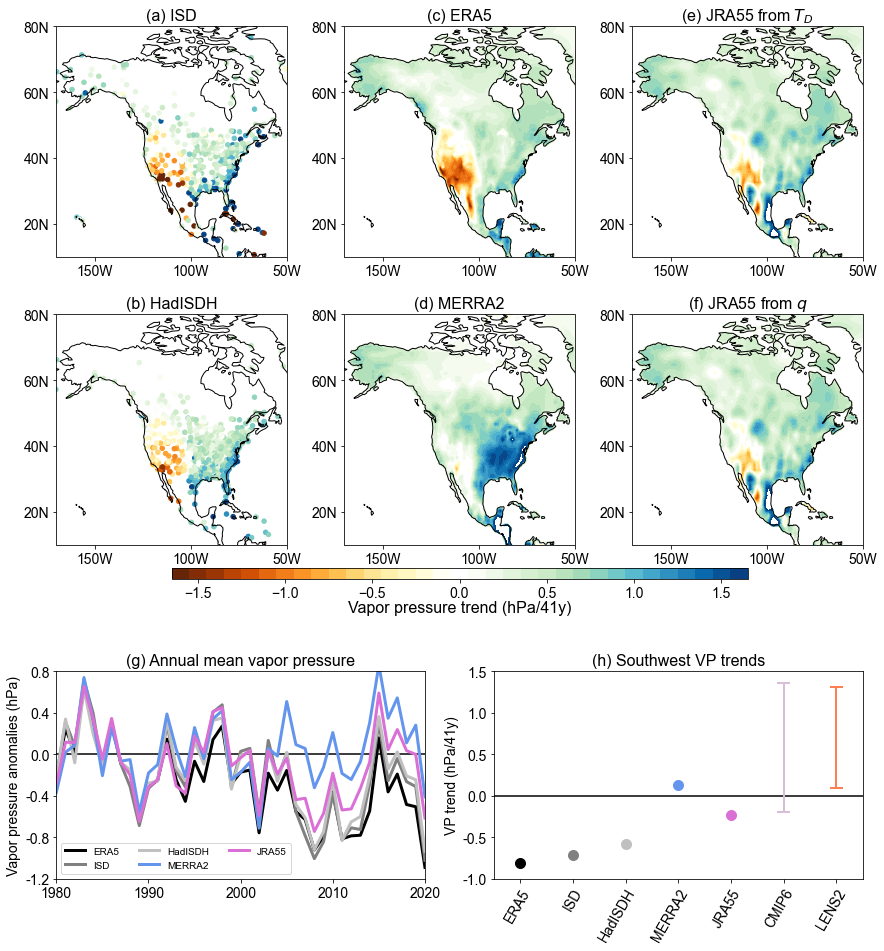

In [13]:
fig = plt.figure(figsize=(16,16))

#------ISD map
ax = mymaps.contourmap_northamerica_scatter_pos(fig, isdmap.vp, isdmap.lons, isdmap.lats, 0.1,-1.6,1.6,'(a) ISD',
                                                0.05,0.25,0.8,1,cmap='precip', fontsize=16)

ax = mymaps.contourmap_northamerica_scatter_pos(fig, hadisdhmap.vp, hadisdhmap.lon, hadisdhmap.lat, 0.1, -1.6, 1.6, '(b) HadISDH',
                                                0.05,0.25,0.55,0.75,cmap='precip', fontsize=16)

#------ERA5 map
ax = mymaps.contourmap_northamerica_fill_pos(fig, era5_map.vp*landfrac, era5_map.lon, era5_map.lat,0.1,-1.6,1.6,'(c) ERA5',
                                           0.3,0.5,0.8,1,cmap='precip', fontsize=16)
#------MERRA2
ax = mymaps.contourmap_northamerica_fill_pos(fig, merra2_map.vp*landfrac, merra2_map.lon, merra2_map.lat, 0.1, -1.6, 1.6,'(d) MERRA2',
                                             0.3,0.5,0.55,0.75,cmap='precip', fontsize=16)


#----JRA55
ax = mymaps.contourmap_northamerica_fill_pos(fig, jra55_map.vp*landfrac, jra55_map.lon, jra55_map.lat, 0.1, -1.6,1.6,'(e) JRA55 from $T_{D}$',
                                             0.55,0.75,0.8,1,cmap='precip', fontsize=16)

#----JRA55 from w
ax = mymaps.contourmap_northamerica_fill_pos(fig, jra55fromq_map.vp*landfrac, jra55fromq_map.lon, jra55fromq_map.lat, 0.1, -1.6, 1.6,'(f) JRA55 from $q$',
                                             0.55,0.75,0.55,0.75,cmap='precip', fontsize=16)

ax = cbars.plotcolorbar(fig, 0.1, -1.6, 1.6,'Vapor pressure trend (hPa/41y)', 0.15,0.65,0.52,0.53,cmap='precip')

ax = fig.add_axes([0.05,0.26,0.32,0.18])
ax.set_ylim(-1.2,0.8)
ax.set_yticks([-1.2,-0.8,-0.4,0,0.4,0.8])
ax.set_yticklabels(['-1.2','-0.8','-0.4','0.0','0.4','0.8'], fontsize=14)
ax.set_xlim(1980,2020)
ax.set_xticks([1980,1990,2000,2010,2020])
ax.set_xticklabels(['1980','1990','2000','2010','2020'], fontsize=14)
ax.set_title('(g) Annual mean vapor pressure', fontsize=16)
ax.set_ylabel('Vapor pressure anomalies (hPa)', fontsize=14)
ax.plot([1980,2020],[0,0], color='black')

ax.plot(era5_am.year, era5_am - era5_am.sel(year=slice(1980,1990)).mean('year'), color='black', linewidth=3, label='ERA5')
ax.plot(isd_am.year, isd_am.vp - isd_am.vp.sel(year=slice(1980,1990)).mean('year'), color='gray', linewidth=3, label='ISD')
ax.plot(hadisdh_am.year, hadisdh_am.vp - hadisdh_am.vp.sel(year=slice(1980,1999)).mean('year'), color='silver', linewidth=3, label='HadISDH')
ax.plot(merra2_am.year, merra2_am - merra2_am.sel(year=slice(1980,1990)).mean('year'), color='cornflowerblue', linewidth=3, label='MERRA2')
ax.plot(jra55_am.year, jra55_am - jra55_am.sel(year=slice(1980,1990)).mean('year'), color='orchid', linewidth=3, label='JRA55')

ax.legend(loc='lower left', ncol=3)


ax = fig.add_axes([0.43,0.26,0.32,0.18])
ax.set_ylim(-1,1.5)
ax.set_xlim(0.5,7.5)
ax.set_yticks([-1,-0.5,0,0.5,1,1.5])
ax.set_yticklabels(['-1.0','-0.5','0.0','0.5','1.0','1.5'], fontsize=14)
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(['ERA5', 'ISD','HadISDH','MERRA2','JRA55','CMIP6','LENS2'], fontsize=14, rotation=60, ha='right', rotation_mode='anchor')
ax.set_ylabel('VP trend (hPa/41y)', fontsize=14)
ax.set_title('(h) Southwest VP trends', fontsize=16)
ax.plot([0,7.5],[0,0], color='black')

ax.plot(1,era5_trend,"o", color='black', markersize=10)
ax.plot(2,isd_trend.vp,"o", color='gray', markersize=10)
ax.plot(3,hadisdh_trend.vp,"o", color='silver', markersize=10)
ax.plot(4,merra2_trend,"o", color='cornflowerblue', markersize=10)
ax.plot(5,jra55_trend,"o", color='orchid', markersize=10)

ax.plot([6,6],[np.min(cmip6_trend), np.max(cmip6_trend)], color='thistle', linewidth=2)
ax.plot([5.9,6.1],[np.min(cmip6_trend), np.min(cmip6_trend)], color='thistle', linewidth=2)
ax.plot([5.9,6.1],[np.max(cmip6_trend), np.max(cmip6_trend)], color='thistle', linewidth=2)
ax.plot([7,7],[np.min(lens2_trend), np.max(lens2_trend)], color='coral', linewidth=2)
ax.plot([6.9,7.1],[np.min(lens2_trend), np.min(lens2_trend)], color='coral', linewidth=2)
ax.plot([6.9,7.1],[np.max(lens2_trend), np.max(lens2_trend)], color='coral', linewidth=2)

fig.savefig(plotpath+'figS2.pdf', bbox_inches='tight', facecolor='white')

In [11]:
import importlib
importlib.reload(mymaps)

<module 'qtrendutils.mapplot_utils' from '/home/islas/python/qtrend_paper/qtrendutils/mapplot_utils.py'>